In [1]:
from fastai import *
from fastai.vision import *
from fastai.vision.models.unet import DynamicUnet
from fastai.vision.learner import cnn_config
from fastai.callbacks import *
import sys
sys.path.append('../../')
sys.path.append('../../model')
from model.losses import *
from model.bpho.resnet import *
from model.bpho.unet import *
from model.metrics import psnr, ssim
from data.load_fluo import *

## data load

In [2]:
gpu_id = 3
num_cores = 4
torch.cuda.set_device(gpu_id)

In [3]:
data_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/')
model_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models/feat_loss')  # path to saved models

In [4]:
bs=8
lr = slice(None, 4e-4, None)
size=512 
tile_sz=512 
# datasetname=multi_100mitotracker 
cycles=100
# save_name=multit_5_100mito_opt_001 
n_frames=5

In [5]:
lr_type = 't'
if lr_type == 's':
    z_frames, t_frames = 1, 1
    n_frames = 1
    dataset = data_pth/'mitotracker_PSSR-SF'
    hr_tifs = dataset/f'hr'
    lr_tifs = dataset/f'lr'
elif lr_type == 't':
    z_frames, t_frames = 1, 5
    n_frames = 5
    multi_str = f'_{lr_type}_{n_frames}'
    tile_sz = 512
    dataset = data_pth/'mitotracker_PSSR-MF'
    hr_tifs = dataset/f'hr_t_{tile_sz:d}{multi_str}'
    lr_tifs = dataset/f'lr_t_{tile_sz:d}{multi_str}'

In [6]:
mode = 'L'
norm = True
noise = False
cutout = False

In [7]:
data = get_data(bs, size, lr_tifs, hr_tifs, n_frames=n_frames,  max_zoom=4., 
                    use_cutout=cutout, use_noise=noise, mode=mode, norm=norm)

normalizing x and y data


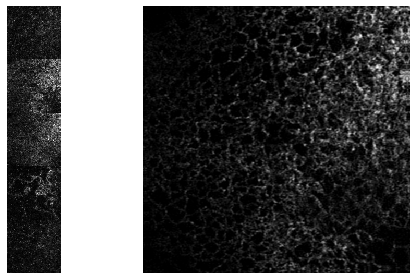

In [8]:
data.show_batch(rows=1, cmap='gray')

## feature loss

In [9]:
critic_pth = Path('/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/models')
critic = load_learner(path=critic_pth/'baselines', file='mitotracker_PSSR-SF_512.pkl')

In [10]:
encoder = critic.model.model[0].eval().float()

In [11]:
feature_maps = find_layers(flatten_model(encoder))
len(feature_maps)

8

In [12]:
feat_loss = FeatureLoss(m_feat=encoder, layer_wgts=[1/8 for _ in range(8)])

## training

In [13]:
wnres_args = {
    'blur': True,
    'blur_final': True,
    'bottle': True,
    'self_attention': True,
    'last_cross': True
    
}
arch = 'wnresnet34'
wd = 1e-3
arch = eval(arch)
metrics = [psnr, ssim]

In [14]:
learn = wnres_unet_learner(data, arch, in_c=n_frames, wnres_args=wnres_args,
                           loss_func=feat_loss, metrics=metrics,
                           model_dir=model_pth, callback_fns=[LossMetrics], wd=wd)

In [15]:
cycles = 100
learn.fit_one_cycle(cycles, max_lr=lr)

epoch,train_loss,valid_loss,psnr,ssim,pixel,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,gram_0,gram_1,gram_2,gram_3,gram_4,gram_5,gram_6,gram_7,time
0,0.213231,0.288721,25.666733,0.208110,0.287138,0.000023,0.000023,0.000889,0.000023,0.000285,0.000023,0.000115,0.000039,0.000000,0.000000,0.000155,0.000000,0.000006,0.000000,0.000000,0.000000,08:16
1,0.203440,0.275643,25.989225,0.235162,0.274006,0.000025,0.000025,0.000905,0.000025,0.000299,0.000025,0.000124,0.000043,0.000000,0.000000,0.000160,0.000000,0.000006,0.000000,0.000000,0.000000,08:22
2,0.191308,0.259821,26.287710,0.250289,0.258162,0.000026,0.000026,0.000914,0.000026,0.000305,0.000026,0.000127,0.000044,0.000000,0.000000,0.000161,0.000000,0.000006,0.000000,0.000000,0.000000,08:22
3,0.186588,0.247774,26.450815,0.258843,0.246055,0.000026,0.000026,0.000940,0.000026,0.000313,0.000026,0.000130,0.000048,0.000000,0.000000,0.000177,0.000000,0.000007,0.000000,0.000000,0.000000,08:19
4,0.185019,0.254356,26.421824,0.261458,0.252677,0.000026,0.000026,0.000921,0.000026,0.000311,0.000026,0.000130,0.000044,0.000000,0.000000,0.000160,0.000000,0.000006,0.000000,0.000000,0.000000,08:17
5,0.184661,0.242728,26.769258,0.270616,0.241060,0.000026,0.000026,0.000915,0.000026,0.000310,0.000026,0.000131,0.000045,0.000000,0.000000,0.000155,0.000000,0.000006,0.000000,0.000000,0.000000,08:21
6,0.183335,0.235186,26.972767,0.274011,0.233517,0.000026,0.000026,0.000915,0.000026,0.000308,0.000026,0.000129,0.000046,0.000000,0.000000,0.000160,0.000000,0.000006,0.000000,0.000000,0.000000,08:18
7,0.180994,0.241014,26.724861,0.274655,0.239341,0.000026,0.000026,0.000920,0.000026,0.000310,0.000026,0.000130,0.000044,0.000000,0.000000,0.000157,0.000000,0.000006,0.000000,0.000000,0.000000,08:21
8,0.179136,0.238580,26.710516,0.278676,0.236857,0.000027,0.000027,0.000939,0.000027,0.000315,0.000027,0.000132,0.000047,0.000000,0.000000,0.000176,0.000000,0.000007,0.000000,0.000000,0.000000,08:19
9,0.174771,0.231749,27.134130,0.285700,0.230106,0.000026,0.000026,0.000904,0.000026,0.000306,0.000026,0.000129,0.000044,0.000000,0.000000,0.000151,0.000000,0.000006,0.000000,0.000000,0.000000,08:22


PermissionError: Caught PermissionError in DataLoader worker process 2.
Original Traceback (most recent call last):
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/_utils/worker.py", line 178, in _worker_loop
    data = fetcher.fetch(index)
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in fetch
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/torch/utils/data/_utils/fetch.py", line 44, in <listcomp>
    data = [self.dataset[idx] for idx in possibly_batched_index]
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/fastai/data_block.py", line 651, in __getitem__
    if self.item is None: x,y = self.x[idxs],self.y[idxs]
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/fastai/data_block.py", line 120, in __getitem__
    if isinstance(idxs, Integral): return self.get(idxs)
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/fastai/vision/data.py", line 271, in get
    res = self.open(fn)
  File "../../model/bpho/multi.py", line 136, in open
    img_data = np.load(fn)
  File "/home/rusl/anaconda3/envs/Salk/lib/python3.7/site-packages/numpy/lib/npyio.py", line 422, in load
    fid = open(os_fspath(file), "rb")
PermissionError: [Errno 13] Permission denied: '/home/alaa/Dropbox/BPHO Staff/USF/Mitotracker/training/trainsets/mitotracker_PSSR-MF/lr_t_512_t_5/train/mitotracker/mitotracker_PSSR-MF_train_lr_1576.npy'


In [17]:
learn.validate()

[0.22735964, tensor(27.2515), tensor(0.2928)]

In [18]:
learn.fit_one_cycle(cycles-14, max_lr=lr)

epoch,train_loss,valid_loss,psnr,ssim,pixel,feat_0,feat_1,feat_2,feat_3,feat_4,feat_5,feat_6,feat_7,gram_0,gram_1,gram_2,gram_3,gram_4,gram_5,gram_6,gram_7,time
0,0.168251,0.224017,27.303553,0.293281,0.222336,0.000027,0.000027,0.000919,0.000027,0.000313,0.000027,0.000132,0.000045,0.000000,0.000000,0.000158,0.000000,0.000006,0.000000,0.000000,0.000000,08:05
1,0.167881,0.222511,27.376717,0.295220,0.220857,0.000026,0.000026,0.000907,0.000026,0.000309,0.000026,0.000131,0.000044,0.000000,0.000000,0.000151,0.000000,0.000006,0.000000,0.000000,0.000000,08:20
2,0.164814,0.222690,27.285828,0.293822,0.221003,0.000027,0.000027,0.000922,0.000027,0.000313,0.000027,0.000133,0.000046,0.000000,0.000000,0.000159,0.000000,0.000006,0.000000,0.000000,0.000000,08:23
3,0.169788,0.223113,27.401655,0.296312,0.221432,0.000027,0.000027,0.000919,0.000027,0.000314,0.000027,0.000133,0.000046,0.000000,0.000000,0.000157,0.000000,0.000006,0.000000,0.000000,0.000000,08:20
4,0.170806,0.224501,27.242537,0.293073,0.222841,0.000027,0.000027,0.000911,0.000027,0.000309,0.000027,0.000131,0.000044,0.000000,0.000000,0.000151,0.000000,0.000006,0.000000,0.000000,0.000000,08:18
5,0.167272,0.221481,27.435757,0.296492,0.219837,0.000027,0.000027,0.000903,0.000027,0.000308,0.000027,0.000132,0.000044,0.000000,0.000000,0.000146,0.000000,0.000006,0.000000,0.000000,0.000000,08:20
6,0.165704,0.220681,27.444086,0.298594,0.219052,0.000026,0.000026,0.000897,0.000026,0.000306,0.000026,0.000130,0.000043,0.000000,0.000000,0.000141,0.000000,0.000005,0.000000,0.000000,0.000000,08:20
7,0.165977,0.226651,27.170218,0.292563,0.224996,0.000026,0.000026,0.000910,0.000026,0.000309,0.000026,0.000131,0.000043,0.000000,0.000000,0.000151,0.000000,0.000006,0.000000,0.000000,0.000000,08:22
8,0.169456,0.228704,27.141722,0.292387,0.226977,0.000027,0.000027,0.000942,0.000027,0.000319,0.000027,0.000134,0.000047,0.000000,0.000000,0.000170,0.000000,0.000006,0.000000,0.000000,0.000000,08:19
9,0.166118,0.211251,27.907822,0.306569,0.209651,0.000026,0.000026,0.000880,0.000026,0.000302,0.000026,0.000128,0.000044,0.000000,0.000000,0.000137,0.000000,0.000005,0.000000,0.000000,0.000000,08:19


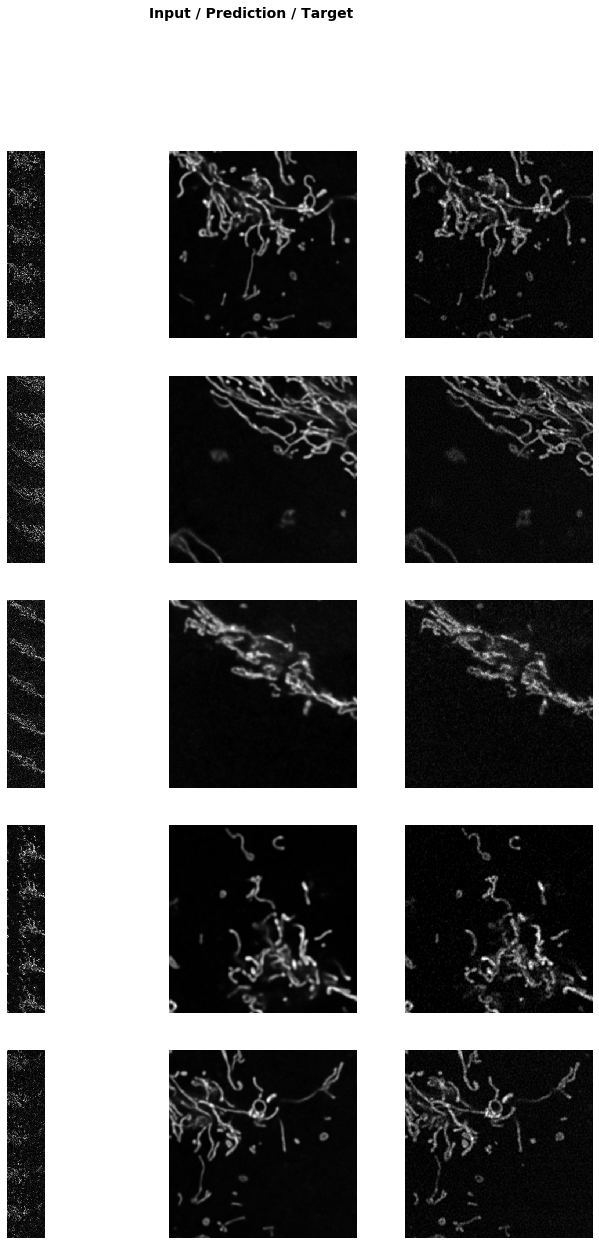

In [19]:
learn.show_results(rows=5, cmap='gray')

In [20]:
save_name = 'fluo_sf_100epoch'
learn.save(save_name)
print(f'saved: {save_name}')

saved: fluo_sf_100epoch
